# Neural Network Final Model - Mace Head, Ireland

In [2]:
import pandas as pd
import numpy as np
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import sys
sys.path.append('../../')
import config as cfg
import functions as f

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [3]:
site = cfg.site
site_name = cfg.site_dict[site]
assert site == 'MHD', 'This script is only for Mace Head, Ireland. The site can be changed in the config file.'

compound = cfg.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Mace Head, Ireland.


### Loading & Initialising Data

In [4]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
34986,2014-09-02 13:00:00,0.0,-0.277397,4.953193,4.235016,-2.178157,-1.260548,-6.404307,-2.500832,3.543169,...,2.207781,5.622525,11.690164,13.722715,-4.072833,-9.252837,3.985906,0.654065,4.440443,7.406368
41141,2018-12-22 15:00:00,1.0,5.504238,4.250927,2.911752,7.906960,5.208407,2.245772,4.027971,-0.607189,...,5.132125,-2.776747,-3.639781,-1.209299,-6.677456,-5.016201,4.961565,17.794506,10.364909,-6.662106
43659,2020-11-30 05:00:00,1.0,7.296004,7.049423,5.996040,7.559350,-4.954812,-5.547863,-5.762312,9.617917,...,7.530505,22.136774,25.236847,15.089675,-14.020445,7.512624,-5.337966,-8.335624,19.007440,22.297710
8253,1994-07-03 19:00:00,1.0,2.890639,-4.904061,-3.707498,-0.684305,-1.083499,3.697163,7.260411,3.534943,...,19.158192,15.012890,11.459774,2.170849,13.946501,10.185780,15.297638,-8.594004,-8.888962,10.220948
2437,1990-04-25 21:00:00,1.0,6.612577,16.865292,9.071711,4.157116,0.916421,2.803307,5.171861,9.098640,...,-2.141576,23.442982,31.495853,20.353436,-8.813770,-0.322769,-16.058283,-18.185884,2.354516,3.263112


In [5]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
# testing set is all remaining datapoints
test_data = data[~data.index.isin(train_data.index) & ~data.index.isin(val_data.index)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-01 01:00:00 -> 2018-12-31 01:00:00. Length: 1354
Val range: 2019-01-04 05:00:00 -> 2019-12-30 13:00:00. Length: 1067
Test range: 1989-02-04 13:00:00 -> 2022-12-31 19:00:00. Length: 43784


### Model

In [6]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(200,150,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.05, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=True,
                         learning_rate_init=0.01,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

class_probabilities_val = nn_model.predict_proba(X_val)
class_probabilities_train = nn_model.predict_proba(X_train)

confidence_threshold = cfg.confidence_threshold

y_pred_val = (class_probabilities_val[:,1] > confidence_threshold).astype(int)
y_pred_train = (class_probabilities_train[:,1] > confidence_threshold).astype(int)

precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)
misclassification_rate_val = 1 - accuracy_score(y_val, y_pred_val)
misclassification_rate_train = 1 - accuracy_score(y_train, y_pred_train)


print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")
print(f"Misclassification Rate on Training Set = {misclassification_rate_train:.3f}")
print(f"Misclassification Rate on Validation Set = {misclassification_rate_val:.3f}")

Precision on Training Set = 0.921
Precision on Validation Set = 0.865
Recall on Training Set = 0.850
Recall on Validation Set = 0.846
F1 Score on Training Set = 0.884
F1 Score on Validation Set = 0.855
Misclassification Rate on Training Set = 0.179
Misclassification Rate on Validation Set = 0.204


In [7]:
class_probabilities_test = nn_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:,1] > confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
misclassification_rate_test = 1 - accuracy_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")
print(f"Misclassification Rate on Testing Set = {misclassification_rate_test:.3f}")

Precision on Testing Set = 0.902
Recall on Testing Set = 0.769
F1 Score on Testing Set = 0.831
Misclassification Rate on Testing Set = 0.252


In [7]:
# saving the model
dump(nn_model, f'../model_files/nn_model_{site}.joblib')

['../model_files/nn_model_MHD.joblib']

### Confusion Matrix

Text(0.5, 1.0, 'Mace Head, Ireland')

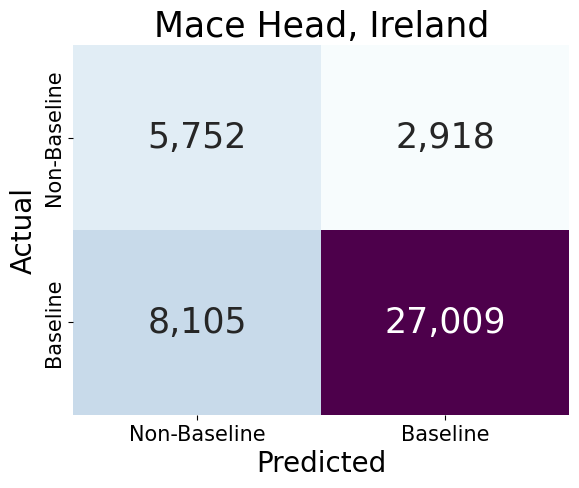

In [9]:
# creating a confusion matrix - large size
conf_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
# renaming the columns
conf_matrix.columns = ['Non-Baseline', 'Baseline']
conf_matrix.index = ['Non-Baseline', 'Baseline']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', cbar=False)
# increasing the font size of the labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
# increasing size of annotation
for t in plt.gca().texts:
    t.set_text(f"{int(t.get_text()):,}")
    t.set_fontsize(25)
plt.title(f'{site_name}', fontsize=25)

Text(0.5, 1.0, 'Mace Head, Ireland')

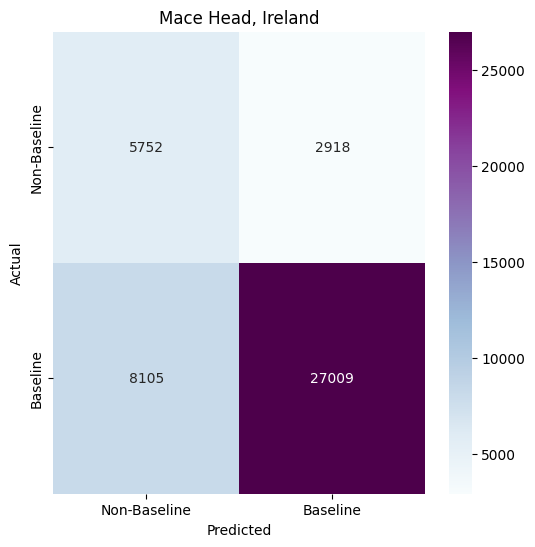

In [8]:
# creating a confusion matrix
conf_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])

conf_matrix.columns = ['Non-Baseline', 'Baseline']
conf_matrix.index = ['Non-Baseline', 'Baseline']

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', cbar=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.set_title(f'{site_name}')

### Assessing Feature Importance

In [9]:
# grouping features by category i.e. x-wind, y-wind, temporal etc.
u_features = [col for col in data.columns if 'u' in col]
v_features = [col for col in data.columns if 'v' in col]
temporal_features = ['day_of_year', 'time_of_day']
sp = ['sp']
blh = ['blh']

groups = [u_features, v_features, temporal_features, sp, blh]

In [10]:
original_score = accuracy_score(y_train, nn_model.predict(X_train))
importances = {}

for group in groups:
    scores_diff = []
    for _ in range(100):
        X_train_permuted = f.permute_group(X_train, group)
        
        permuted_score = accuracy_score(y_train, nn_model.predict(X_train_permuted))
        scores_diff.append(original_score - permuted_score)
    
    importances[str(group)] = np.mean(scores_diff)

# Sort groups by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=False)

In [11]:
# matching the group names to the sorted importances
n = len(groups)
group_names_sorted = []

for i in range(n):
    name = sorted_importances[i][0]

    if 'u10_0' in name:
        group_names_sorted.append('u-wind')

    elif 'v10_0' in name:
        group_names_sorted.append('v-wind')

    elif 'day_of_year' in name:
        group_names_sorted.append('temporal')

    elif 'sp' in name:
        group_names_sorted.append('sp')

    elif 'blh' in name:
        group_names_sorted.append('blh')

Text(0, 0.5, 'Feature Group')

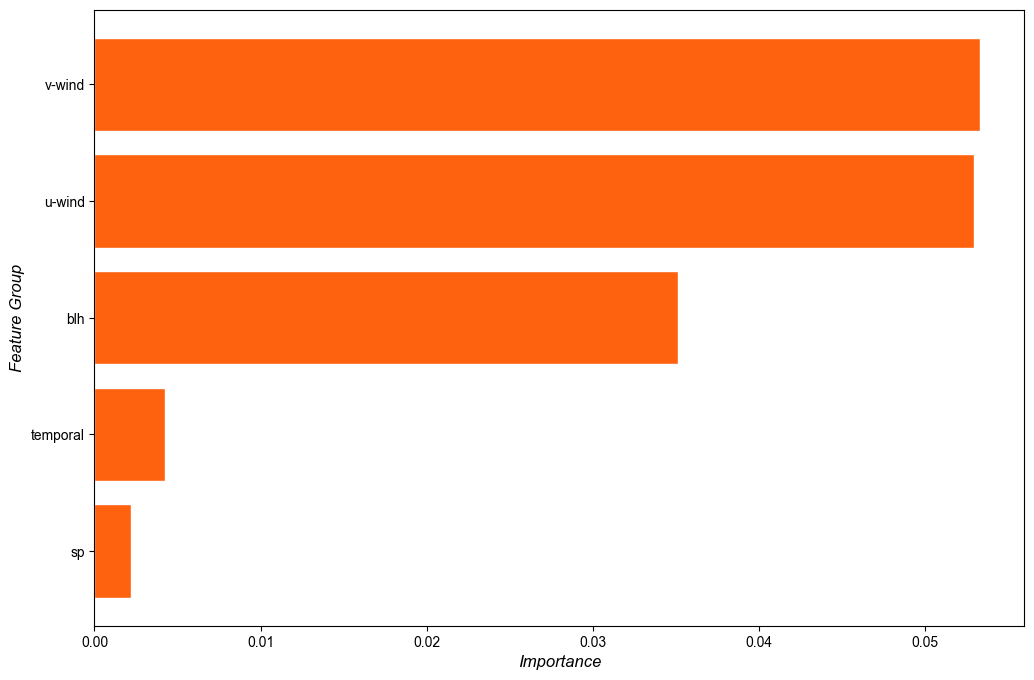

In [12]:
# Plotting the importances of the groups
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_theme(style='ticks', font='Arial')

ax.barh(group_names_sorted, [importance for _, importance in sorted_importances], color='#FF620E')

ax.set_xlabel('Importance', fontsize=12, fontstyle='italic')
ax.set_ylabel('Feature Group', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importances', fontsize=14)